# Spam Classifier

Use this notebook to train a classyfier for the Apache SpamAssassin data, and pick the best one!

In [1]:
import os
import sys
import email
import email.policy
import numpy as np

from collections import Counter
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
SPAM_DIR = "./data/spam"
HAM_DIR = "./data/ham"

### Load data

Download the spam emails by runnig 

`python startup.py`

In [3]:
# Load all the emails
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if name != 'cmds']
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if name != 'cmds']

In [4]:
len(ham_filenames)

4150

In [5]:
len(spam_filenames)

1897

In [6]:
def load_emails(directory, filename):
    with open(os.path.join(directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [7]:
ham_emails = [load_emails(HAM_DIR, filename=name) for name in ham_filenames]
spam_emails = [load_emails(SPAM_DIR, filename=name) for name in spam_filenames]

In [8]:
len(ham_emails)

4150

In [9]:
len(spam_emails)

1897

## Spam / Ham emails

Let's familiarize with the data:

In [10]:
spam_emails[20].get_content()

'Cellular Phone Accessories All At Below Wholesale Prices!\n\nhttp://202.101.163.34:81/sites/merchant/sales/\n\nHands Free Ear Buds 1.99! \nPhone Holsters 1.98! \nBooster Antennas Only $0.99\nPhone Cases 1.98! \nCar Chargers 1.98! \nFace Plates As Low As 0.99! \nLithium Ion Batteries As Low As 6.94! \n\nhttp://202.101.163.34:81/sites/merchant/sales/\n\nClick Below For Accessories On All NOKIA, MOTOROLA LG, NEXTEL, \nSAMSUNG, QUALCOMM, ERICSSON, AUDIOVOX PHONES At Below \nWHOLESALE PRICES!\n\nhttp://202.101.163.34:81/sites/merchant/sales/\n\n***If You Need Assistance Please Call Us (732) 751-1457***\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\nTo be removed from future mailings please send your remove \nrequest to: removemenow68994@btamail.net.cn \nThank You and have a super day :)\n\n'

In [11]:
# get email headers
for header, value in spam_emails[20].items():
    print(header,":",value)

Return-Path : <hurst@missouri.co.jp>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 2667B44156	for <zzzz@localhost>; Fri, 23 Aug 2002 06:02:51 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Fri, 23 Aug 2002 11:02:51 +0100 (IST)
Received : from toole.uol.com.br (toole.uol.com.br [200.231.206.186])	by webnote.net (8.9.3/8.9.3) with ESMTP id WAA06855;	Thu, 22 Aug 2002 22:28:56 +0100
From : hurst@missouri.co.jp
Received : from activatormail.com ([200.158.104.164])	by toole.uol.com.br (8.9.1/8.9.1) with SMTP id SAA13079;	Thu, 22 Aug 2002 18:21:49 -0300 (BRT)
Message-ID : <000023b8700d$00003a16$00004696@missouri.co.jp>
To : hurst@missouri.co.jp
Subject : ^^^^^Cell Phone Belt Clips $1.95^^^^^^                           18070
Date : Thu, 22 Aug 2002 15:45:31 -0600
MIME-Version : 1.0
Conte

In [12]:
ham_emails[10].get_content().strip()

"Klez: The Virus That Won't Die\n \nAlready the most prolific virus ever, Klez continues to wreak havoc.\n\nAndrew Brandt\n>>From the September 2002 issue of PC World magazine\nPosted Thursday, August 01, 2002\n\n\nThe Klez worm is approaching its seventh month of wriggling across \nthe Web, making it one of the most persistent viruses ever. And \nexperts warn that it may be a harbinger of new viruses that use a \ncombination of pernicious approaches to go from PC to PC.\n\nAntivirus software makers Symantec and McAfee both report more than \n2000 new infections daily, with no sign of letup at press time. The \nBritish security firm MessageLabs estimates that 1 in every 300 \ne-mail messages holds a variation of the Klez virus, and says that \nKlez has already surpassed last summer's SirCam as the most prolific \nvirus ever.\n\nAnd some newer Klez variants aren't merely nuisances--they can carry \nother viruses in them that corrupt your data.\n\n...\n\nhttp://www.pcworld.com/news/artic

In [13]:
# get email headers
for header, value in ham_emails[10].items():
    print(header,":",value)

Return-Path : <irregulars-admin@tb.tf>
Delivered-To : zzzz@localhost.netnoteinc.com
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id 9DAE147C66	for <zzzz@localhost>; Thu, 22 Aug 2002 09:23:38 -0400 (EDT)
Received : from phobos [127.0.0.1]	by localhost with IMAP (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 14:23:38 +0100 (IST)
Received : from web.tb.tf (route-64-131-126-36.telocity.com    [64.131.126.36]) by dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id    g7MDGOZ07922 for <zzzz-irr@spamassassin.taint.org>; Thu, 22 Aug 2002 14:16:24 +0100
Received : from web.tb.tf (localhost.localdomain [127.0.0.1]) by web.tb.tf    (8.11.6/8.11.6) with ESMTP id g7MDP9I16418; Thu, 22 Aug 2002 09:25:09    -0400
Received : from red.harvee.home (red [192.168.25.1] (may be forged)) by    web.tb.tf (8.11.6/8.11.6) with ESMTP id g7MDO4I16408 for    <irregulars@tb.tf>; Thu, 22 Aug 2002 09:24:04 -0400
Received : from prserv.net (o

Some emails have a more complex structure: they are multiparts, made with text, images and attachements. To analyse their structure, we will use the following functions from the book 'Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow' by A. Geron.

In [14]:
from collections import Counter

def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()
    

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [15]:
structures_counter(ham_emails).most_common()

[('text/plain', 3832),
 ('text/html', 120),
 ('multipart(text/plain, application/pgp-signature)', 101),
 ('multipart(text/plain, text/html)', 63),
 ('multipart(text/plain, text/plain)', 5),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 2),
 ('multipart(text/plain, application/x-pkcs7-signature)', 2),
 ('multipart(text/html)', 2),
 ('multipart(text/plain, multipart(text/plain))', 2),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  2),
 ('multipart(text/plain, image/bmp)', 1),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(multipart(text/plain, text/html))', 1),
 ('multipart(text/plain, image/png, image/png)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/jpeg, image/gif, image/gif, image/gif, image/gif, image

In [16]:
structures_counter(spam_emails).most_common()

[('text/plain', 816),
 ('text/html', 772),
 ('multipart(text/plain, text/html)', 159),
 ('multipart(text/html)', 49),
 ('multipart(text/plain)', 44),
 ('multipart(multipart(text/html))', 23),
 ('multipart(multipart(text/plain, text/html))', 5),
 ('multipart(text/plain, application/octet-stream, text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 3),
 ('multipart(text/html, text/plain)', 3),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart/alternative', 2),
 ('multipart(text/html, image/jpeg)', 2),
 ('multipart(multipart(text/plain), application/octet-stream)', 2),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(multipart(text/plain, text/html), image/jpeg, image/jpeg, image/jpeg, image/jpeg, image/jpeg)',
  1),
 ('multipart(multipart(text/plain, text/html), image/jpeg, image/jpeg, image/jpeg, image/jpeg, image/gif)',
  1),
 ('text/plain charset=us-ascii', 1),
 ('multipart(multipart(text

 ## Process the data

Now that we know the structure of the data, we can transform them in order to train the spam classfiers.

First, we split the data into a train and a test set.

In [17]:
X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We will use `preprocess.py` script to transform data. 
The script runs a Preprocess Pipeline : first the emails get cleaned and trasnformed in plain text, then each word in the email gets vectorized.

In [18]:
sys.path.append('./preprocess.py')
from preprocess import process_emails

X_train_processed = process_emails.fit_transform(X_train)
X_test_processed = process_emails.transform(X_test)

In [19]:
print(X_train_processed.shape)
print(X_test_processed.shape)

(4837, 53203)
(1210, 53203)


## Classifiers

The classifier that we are going to train and evaluate are:

- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)
- [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
- [AdaBoostClassfier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)
- [KNNClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
- [NaiveBayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)
- [(Linear) SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)


Each of the classfier will be trained using a *3-fold cross validation*. Then, we will evaluate the **confusion matrix, precision, recall and f1-score**. We will also plot the *precision* vs *recall curve*,  *ROC curve* and calculate the *ROC AUC*.

Finally, we will pick the classifier with the highest recall and precision. 

To achieve this, we first need to import the python scripts `classifiers.py` and `evaluation.py`, which contains the functions to define, train and evaluate the classifiers.

In [20]:
sys.path.append('./classifiers.py')
from classifiers import Classifiers

In [21]:
clfs = Classifiers()

Let's make predictions for each model

In [22]:
predictions = clfs.predict(X_train_processed.toarray(), y_train)

SGD: done!
MLP: done!
Decision Tree: done!
Random Forest: done!
AdaBoost: done!
KNN: done!
NB: done!
SVM: done!


In [23]:
predictions.keys()

dict_keys(['SGD', 'MLP', 'Decision Tree', 'Random Forest', 'AdaBoost', 'KNN', 'NB', 'SVM'])

### Evaluate classifiers
We now evaluate each classifier. We will look at the following performance measures:

* **confusion matrix**: how many times a spam email is classified as spam or as ham
* **accuracy**: how many correct classifications
* **precision**: accuracy of correct predictions, in other words TP/(TP + FP)
* **recall**: the ratio of correct predictions, in other words TP/(TP + FN)
* **f1 score**: the harmonic mean of precision and recall, in other words 2/(1/precision + 1/recall)

where:

* **TP**: No. of True positive, in our case how many spam emails are predicted as such
* **FP**: No. of False positive, how many ham emails are predicted as spam
* **FN**: No. of False negative, how many spam emails are predicted as ham

In [24]:
evaluations = clfs.evaluate(y_train, predictions)

SGD: done!
MLP: done!
Decision Tree: done!
Random Forest: done!
AdaBoost: done!
KNN: done!
NB: done!
SVM: done!


In [25]:
for clf_name in evaluations.keys():
    print("{}:".format(clf_name))
    print("confusion matrix: \n {}".format(evaluations[clf_name]['confusion_matrix']))
    print("accuracy: {}".format(evaluations[clf_name]['accuracy_score']))
    print("precision: {}".format(evaluations[clf_name]['precision_score']))
    print("recall: {}".format(evaluations[clf_name]['recall_score']))
    print("f1-score: {}".format(evaluations[clf_name]['f1_score']))
    print()

SGD:
confusion matrix: 
 [[3248   71]
 [  72 1446]]
accuracy: 0.9704362207980153
precision: 0.9531970995385629
recall: 0.9525691699604744
f1-score: 0.9528830313014828

MLP:
confusion matrix: 
 [[3290   29]
 [  70 1448]]
accuracy: 0.9795327682447799
precision: 0.980365605958023
recall: 0.9538866930171278
f1-score: 0.9669449081803005

Decision Tree:
confusion matrix: 
 [[3158  161]
 [ 123 1395]]
accuracy: 0.941285921025429
precision: 0.8965295629820051
recall: 0.9189723320158103
f1-score: 0.9076122316200391

Random Forest:
confusion matrix: 
 [[3277   42]
 [ 191 1327]]
accuracy: 0.9518296464750878
precision: 0.9693206720233747
recall: 0.8741765480895916
f1-score: 0.9192933841357811

AdaBoost:
confusion matrix: 
 [[3240   79]
 [  91 1427]]
accuracy: 0.9648542485011371
precision: 0.9475431606905711
recall: 0.9400527009222661
f1-score: 0.9437830687830687

KNN:
confusion matrix: 
 [[3020  299]
 [ 169 1349]]
accuracy: 0.9032458135207774
precision: 0.8185679611650486
recall: 0.88866930171278
f

From the above data, the most promising model seems to be **MLP**, while the least promising seems **SVM**. 

To select a model with a good precision/recall trade-off, we are going to look at the _precision versus recall_ curve.  We will also plot the threshold.

In [26]:
sys.path.append('./curves.py')
from curves import PlotCurves

In [27]:
plot_curves = PlotCurves(predictions, X_train_processed.toarray(), y_train)

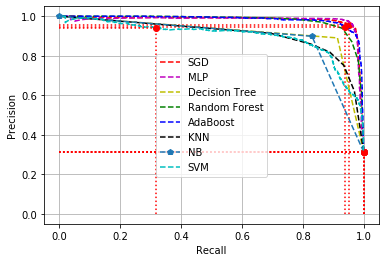

In [28]:
plot_curves.precision_vs_recall(clf_list = 'all', thr = 'default')

The plot above shows that most of the classifiers have the best recall/precision trade-off at the default thresholds at 0. Instead, SVM and NB seem to have a better trade-off at around 0.9 precision/recall. Increasing the threshold for SVM we obtain the following:

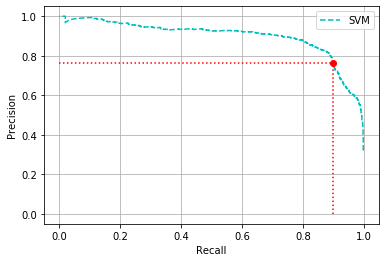

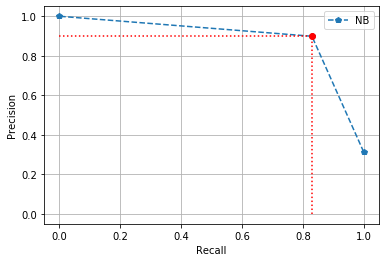

In [29]:
# in curves.py use  `threshold = thresholds[np.argmax((recalls <= 0.9))]` instead of 0
plot_curves.precision_vs_recall(['SVM'], thr='best')
plot_curves.precision_vs_recall(['NB'], thr='best')

Finally, let's look at the **ROC curve** (receiver operating characterist curve) for each classifier. This curve plots the recall (also called *sensitivity*) against the false positive rate (also called *specificity*).

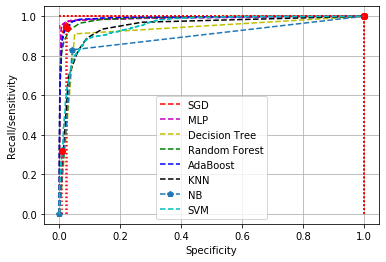

In [30]:
plot_curves.roc_curve(clf_list = 'all', thr = 'default')

To compare classifiers using the ROC curve, it is common to compute the **AUC**, the *area under the curve*: better the classifier, more the AUC tends to 1: 

In [31]:
plot_curves.roc_auc_score(clf_list = 'all')

ROC AUC scores:
SGD: 0.9896164177901737
MLP: 0.9887220582099867
Decision Tree: 0.9325490915283545
Random Forest: 0.9872819725610639
AdaBoost: 0.9912840629727592
KNN: 0.9469695977287316
NB: 0.8936277773080373
SVM: 0.9524506762477863


From the above data, the most promising classifiers are:
* MLP
* AdaBoost
* SGD

### Fine-tune classifiers

Now that we have a shortlist of promising models we can fine-tune them before picking the 'best'.

To fine tune the models we will use either **Grid** or **Randomized** search (according to the model), and then evaluate them on the test data before choosing one.

In [32]:
# Fine tune MLP
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


mlp_best = MLPClassifier()
# param to test
mlp_param_grid = {
    'hidden_layer_sizes': [(16,), (16, 16), (32,)],
    'activation': ['relu', 'tanh', 'logistic']
}

# search the best params for adaboost
mlp_grid_search = GridSearchCV(mlp_best, mlp_param_grid, 'f1', cv=5, verbose=2)
mlp_grid_search.fit(X_train_processed, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] activation=relu, hidden_layer_sizes=(16,) .......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ activation=relu, hidden_layer_sizes=(16,), total=  18.7s
[CV] activation=relu, hidden_layer_sizes=(16,) .......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s remaining:    0.0s


[CV] ........ activation=relu, hidden_layer_sizes=(16,), total=  16.4s
[CV] activation=relu, hidden_layer_sizes=(16,) .......................
[CV] ........ activation=relu, hidden_layer_sizes=(16,), total=  14.3s
[CV] activation=relu, hidden_layer_sizes=(16,) .......................
[CV] ........ activation=relu, hidden_layer_sizes=(16,), total=  15.0s
[CV] activation=relu, hidden_layer_sizes=(16,) .......................
[CV] ........ activation=relu, hidden_layer_sizes=(16,), total=  13.4s
[CV] activation=relu, hidden_layer_sizes=(16, 16) ....................
[CV] ..... activation=relu, hidden_layer_sizes=(16, 16), total=  14.6s
[CV] activation=relu, hidden_layer_sizes=(16, 16) ....................
[CV] ..... activation=relu, hidden_layer_sizes=(16, 16), total=  10.7s
[CV] activation=relu, hidden_layer_sizes=(16, 16) ....................
[CV] ..... activation=relu, hidden_layer_sizes=(16, 16), total=  12.7s
[CV] activation=relu, hidden_layer_sizes=(16, 16) ....................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 20.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'activation': ['relu', 'tanh', 'logistic'

In [33]:
# Fine tune AdaBoost
from sklearn.ensemble import AdaBoostClassifier

adaboost_best = AdaBoostClassifier()
# param to test
adaboost_param_grid = {
    'n_estimators': [10, 30, 50, 100]
}

# search the best params for mlp
adaboost_grid_search = GridSearchCV(adaboost_best, adaboost_param_grid, 'f1', cv=5, verbose=1)
adaboost_grid_search.fit(X_train_processed, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=None,
             param_grid={'n_estimators': [10, 30, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

In [34]:
# Fine tune SGD
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV


sgd_best = SGDClassifier()
# param to test
sgd_param_search = {
    'alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'penalty': ['l2'],
    'n_jobs': [-1]
}

# search the best params for sgd
sgd_randomized_search = RandomizedSearchCV(sgd_best, sgd_param_search, n_iter=5, scoring='f1',
                                           cv=5, verbose=2, random_state=42)
sgd_randomized_search.fit(X_train_processed, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] penalty=l2, n_jobs=-1, alpha=1e-06 ..............................
[CV] ............... penalty=l2, n_jobs=-1, alpha=1e-06, total=   0.1s
[CV] penalty=l2, n_jobs=-1, alpha=1e-06 ..............................
[CV] ............... penalty=l2, n_jobs=-1, alpha=1e-06, total=   0.0s
[CV] penalty=l2, n_jobs=-1, alpha=1e-06 ..............................
[CV] ............... penalty=l2, n_jobs=-1, alpha=1e-06, total=   0.0s
[CV] penalty=l2, n_jobs=-1, alpha=1e-06 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............... penalty=l2, n_jobs=-1, alpha=1e-06, total=   0.1s
[CV] penalty=l2, n_jobs=-1, alpha=1e-06 ..............................
[CV] ............... penalty=l2, n_jobs=-1, alpha=1e-06, total=   0.1s
[CV] penalty=l2, n_jobs=-1, alpha=0.01 ...............................
[CV] ................ penalty=l2, n_jobs=-1, alpha=0.01, total=   0.0s
[CV] penalty=l2, n_jobs=-1, alpha=0.01 ...............................
[CV] ................ penalty=l2, n_jobs=-1, alpha=0.01, total=   0.0s
[CV] penalty=l2, n_jobs=-1, alpha=0.01 ...............................
[CV] ................ penalty=l2, n_jobs=-1, alpha=0.01, total=   0.0s
[CV] penalty=l2, n_jobs=-1, alpha=0.01 ...............................
[CV] ................ penalty=l2, n_jobs=-1, alpha=0.01, total=   0.0s
[CV] penalty=l2, n_jobs=-1, alpha=0.01 ...............................
[CV] ................ penalty=l2, n_jobs=-1, alpha=0.01, total=   0.0s
[CV] penalty=l2, n_jobs=-1, alpha=1e-07 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.1s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=None, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   iid='warn', n_iter=5, n_jobs=None,
                   param_distri

In [35]:
# Get the best estimators
mlp_best = mlp_grid_search.best_estimator_
adaboost_best = adaboost_grid_search.best_estimator_
sgd_best = sgd_randomized_search.best_estimator_

Let's evaluate each fine tuned model on the training and test set

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [37]:
# Evaluate each model on the training set
best_clf = {
    'MLP': mlp_best,
    'AdaBoost': adaboost_best,
    'SGD': sgd_best
}

# predict
best_ypreds = {}
for clf_name, clf in best_clf.items():
    best_ypreds[clf_name] = clf.predict(X_train_processed)

# evaluate
for clf_name, y_pred in best_ypreds.items():
    print("{}:".format(clf_name))
    print("confusion matrix: \n {}".format(confusion_matrix(y_train, y_pred)))
    print("accuracy: {}".format(accuracy_score(y_train, y_pred)))
    print("precision: {}".format(precision_score(y_train, y_pred)))
    print("recall: {}".format(recall_score(y_train, y_pred)))
    print("f1-score: {}".format(f1_score(y_train, y_pred)))
    print()

MLP:
confusion matrix: 
 [[3318    1]
 [   1 1517]]
accuracy: 0.9995865205706016
precision: 0.9993412384716732
recall: 0.9993412384716732
f1-score: 0.9993412384716732

AdaBoost:
confusion matrix: 
 [[3299   20]
 [  34 1484]]
accuracy: 0.9888360554062435
precision: 0.9867021276595744
recall: 0.9776021080368906
f1-score: 0.9821310390469887

SGD:
confusion matrix: 
 [[3319    0]
 [   2 1516]]
accuracy: 0.9995865205706016
precision: 1.0
recall: 0.9986824769433466
f1-score: 0.999340804218853



In [38]:
# Evaluate each model on the test set

# predict
best_ypreds = {}
for clf_name, clf in best_clf.items():
    best_ypreds[clf_name] = clf.predict(X_test_processed)

# evaluate
for clf_name, y_pred in best_ypreds.items():
    print("{}:".format(clf_name))
    print("confusion matrix: \n {}".format(confusion_matrix(y_test, y_pred)))
    print("accuracy: {}".format(accuracy_score(y_test, y_pred)))
    print("precision: {}".format(precision_score(y_test, y_pred)))
    print("recall: {}".format(recall_score(y_test, y_pred)))
    print("f1-score: {}".format(f1_score(y_test, y_pred)))
    print()

MLP:
confusion matrix: 
 [[820  11]
 [ 14 365]]
accuracy: 0.9793388429752066
precision: 0.9707446808510638
recall: 0.9630606860158312
f1-score: 0.966887417218543

AdaBoost:
confusion matrix: 
 [[823   8]
 [ 18 361]]
accuracy: 0.9785123966942149
precision: 0.978319783197832
recall: 0.9525065963060686
f1-score: 0.96524064171123

SGD:
confusion matrix: 
 [[817  14]
 [ 13 366]]
accuracy: 0.9776859504132231
precision: 0.9631578947368421
recall: 0.9656992084432717
f1-score: 0.9644268774703557



# Conclusions

After fine tuning our shortlisted classifiers, we can say that the 'best' classifier is **MLP** with the following metrics:
* accuracy: 91.5%
* precision: 85.6%
* recall: 87.6%
* f1-score: 86.6 %

The above 'best' model can be saved for future uses:

In [39]:
import pickle

output = open('mlp_best.pkl', 'wb')
pickle.dump(mlp_best, output)
output.close()
print(mlp_best)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(16, 16), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
